# Pneumonia Diagnosis from X-Ray Images Using Deep Learning
by Kevin Atkinson, Gideon Miles, and Alison Park

## Business Understanding

Radiology is a crucial aspect of modern medicine, yet it remains inaccessible to a staggering 60% of the global population. While efforts to donate equipment and train technicians have improved accessibility to radiological services, the scarcity of skilled radiologists in many countries remains a challenge.

Telemedicine has emerged as a solution to circumvent this obstacle by facilitating the remote reading of scans by radiologists in other locations. However, this process can be time-consuming, with each scan taking an average of 10 minutes to read, delaying the diagnosis and treatment of critical conditions such as pneumonia.

Pneumonia is a leading cause of mortality among young children worldwide, claiming the lives of approximately 800,000 children under the age of five every year, according to the World Health Organization. Early diagnosis and prompt treatment are essential to improving patient outcomes and reducing healthcare costs, as delayed diagnosis can lead to extended hospital stays and higher mortality rates.

Research indicates that rapid diagnostic tests for pneumonia can significantly reduce the overuse of antibiotics, shorten hospital stays, and lower healthcare costs. Although a neural network cannot replace the expertise of a trained physician, developing tools to assist in the rapid and accurate diagnosis of radiological scans can improve the efficiency of healthcare services, enabling doctors to diagnose and treat more patients within the same time frame.

Our goal for this project is to create a Convolutional Neural Network capable of classifying X-Rays of patients with Pneumonia.


## Data Understanding

The data is collection of about 6000 X-rays of Children’s lungs taken by the university of California San Diego. University of California San Diego, Guangzhou Women and Children’s Medical Center Back in 2018.

In order to make our model more robust we used what is called a data generator. In essence it takes know pictures and makes slight alterations to them to improve the models performance.

It takes an image, alters it, rotates its removes edges, alters the orientation of the image, changes the brightness all to create more examples for the model to train.

When done right it allows for various perspectives of the same image, think of it like taking multiple pictures of an object but from a different angle to get a better

Not every lung is positioned the same way when it is scanned. By giving more orientations the model could become more robust effectively making our limited data set a much large one but use of altering the information.

In [1]:
import os
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.io import decode_jpeg
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, LayerNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator

In [2]:
# get current directory, join with data paths
cwd = os.getcwd()
train_path = os.path.join(cwd, 'Data/train')
test_path = os.path.join(cwd, 'Data/test')
train_path

'/Users/Gideon/Desktop/FlatIron/xrayid/Data/train'

In [3]:
# create lists of images within data folders
pneumonia_filenames = os.listdir(os.path.join(train_path, 'pneumonia'))
normal_filenames = os.listdir(os.path.join(train_path, 'normal'))
pneumonia_filenames[:5]

['BACTERIA-4038442-0001.jpeg',
 'BACTERIA-8034950-0011.jpeg',
 'BACTERIA-292199-0002.jpeg',
 'BACTERIA-2092977-0003.jpeg',
 'BACTERIA-4407438-0002.jpeg']

## Examples of Pneumonia

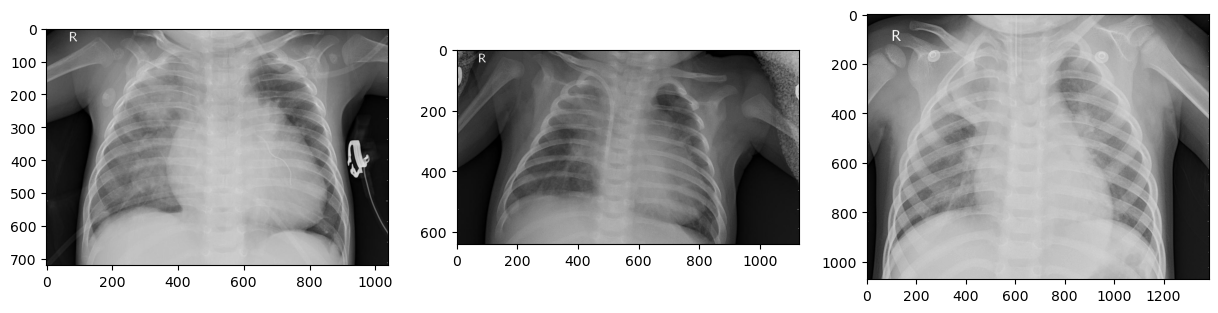

In [4]:
plt.figure(figsize=(15,15))
for i in range(3):
    filename = pneumonia_filenames[i]
    img_addr = train_path + '/pneumonia/' + filename
    img = Image.open(img_addr)
    ax = plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')

## Examples of Healthy Lungs

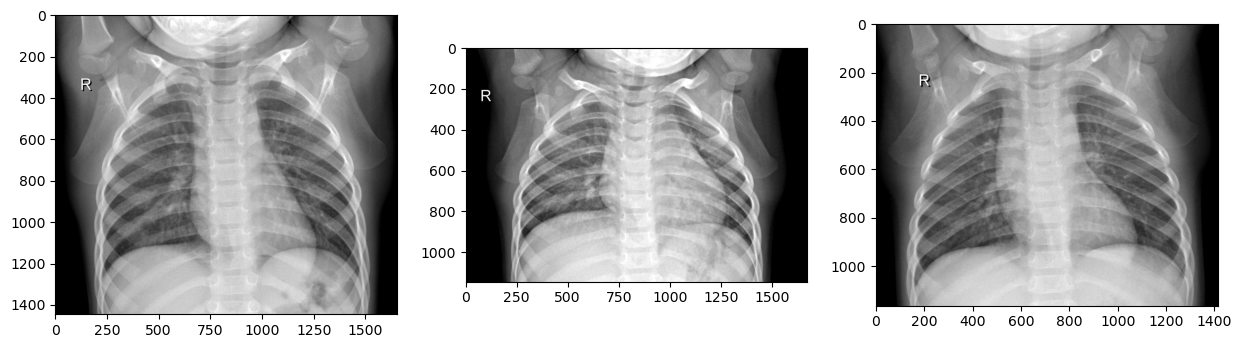

In [5]:
plt.figure(figsize=(15,15))
for i in range(3):
    filename = normal_filenames[i]
    img_addr = train_path + '/normal/' + filename
    img = Image.open(img_addr)
    ax = plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')

## Required Functions

In order to streamline model creation and exploration we will create a function to define ImageDataGenerators, and then plot the results of our models

In [6]:
# This function creates image generators for train and validation to be used in our models
# We can call this function and alter its arguments in order to determine which model works best for our needs
def ImgGen(data_path, img_size=(128,128), batch_size=32, brightness=[0.8, 1.2], vsplit=0.2, rrange=10, seed=2023, shuffle=True):
    train_datagen = ImageDataGenerator(validation_split=vsplit, rotation_range=rrange, fill_mode='nearest',
                                   brightness_range=brightness, rescale=1./255)
    train_gen = train_datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size,
                                                    class_mode='binary', color_mode='grayscale', subset='training',
                                                    shuffle=shuffle, seed=seed)
    val_gen = train_datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size,
                                                    class_mode='binary', color_mode='grayscale', subset='validation',
                                                    shuffle=shuffle, seed=seed)
    return train_gen, val_gen

In [8]:
train_gen1, val_gen1 = ImgGen(train_path)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [9]:
train_gen1.filenames

['NORMAL/NORMAL-2801235-0001.jpeg',
 'NORMAL/NORMAL-2808220-0001.jpeg',
 'NORMAL/NORMAL-2823265-0001.jpeg',
 'NORMAL/NORMAL-284113-0001.jpeg',
 'NORMAL/NORMAL-284113-0002.jpeg',
 'NORMAL/NORMAL-284113-0003.jpeg',
 'NORMAL/NORMAL-28501-0001.jpeg',
 'NORMAL/NORMAL-2860555-0001.jpeg',
 'NORMAL/NORMAL-2881687-0001.jpeg',
 'NORMAL/NORMAL-2881863-0001.jpeg',
 'NORMAL/NORMAL-2885344-0001.jpeg',
 'NORMAL/NORMAL-2890238-0001.jpeg',
 'NORMAL/NORMAL-2914942-0001.jpeg',
 'NORMAL/NORMAL-2926567-0001.jpeg',
 'NORMAL/NORMAL-293382-0001.jpeg',
 'NORMAL/NORMAL-2949692-0001.jpeg',
 'NORMAL/NORMAL-2957919-0001.jpeg',
 'NORMAL/NORMAL-2983256-0001.jpeg',
 'NORMAL/NORMAL-2984327-0001.jpeg',
 'NORMAL/NORMAL-2986373-0001.jpeg',
 'NORMAL/NORMAL-2992797-0001.jpeg',
 'NORMAL/NORMAL-2992797-0002.jpeg',
 'NORMAL/NORMAL-2996766-0001.jpeg',
 'NORMAL/NORMAL-3006949-0001.jpeg',
 'NORMAL/NORMAL-3006949-0002.jpeg',
 'NORMAL/NORMAL-3037101-0001.jpeg',
 'NORMAL/NORMAL-3040444-0001.jpeg',
 'NORMAL/NORMAL-3054452-0001.jpeg'

While we're creating generators, let's also create an evaluation generator to analyze the efficacy of our model after training, as well as a test generator to be used once we have our final model selected.

In [10]:
# creating generators to use for evaluation
eval_datagen = ImageDataGenerator(rescale=1./255)
eval_gen = eval_datagen.flow_from_directory(train_path, target_size=(128,128), batch_size=32, class_mode='binary',
                                                  color_mode='grayscale', shuffle=False)

Found 5232 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
# Test generator for shape (128,128)
test_gen1 = test_datagen.flow_from_directory(test_path, target_size=(128,128), batch_size=32, class_mode='binary',
                                                  color_mode='grayscale', shuffle=False)

# Test generator for shape (256,256)
test_gen2 = test_datagen.flow_from_directory(test_path, target_size=(256,256), batch_size=32, class_mode='binary',
                                                  color_mode='grayscale', shuffle=False)

Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
# This function 
def plot_history(history):
    train_loss = history.history['loss']
    train_recall = history.history['recall']
    val_loss = history.history['val_loss']
    val_recall = history.history['val_recall']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('Loss')
    ax2.set_title('Recall')
    ax1.set_ylim([0, None])
    ax2.set_ylim([0, None])
    sns.lineplot(x=history.epoch, y=train_loss, ax=ax1, label='Training')
    sns.lineplot(x=history.epoch, y=val_loss, ax=ax1, label='Validation')
    sns.lineplot(x=history.epoch, y=train_recall, ax=ax2, label='Training')
    sns.lineplot(x=history.epoch, y=val_recall, ax=ax2, label='Validation')

## Data Augmentation

In order to create a model capable of adapting to X-Rays of varying brightness and orientation, we can use TensorFlow's ImageDataGenerator to load and augment files within our data folder.

### Examples of Augmented Images, Labelled by Class

Here are examples of the output of the Image Data Generator

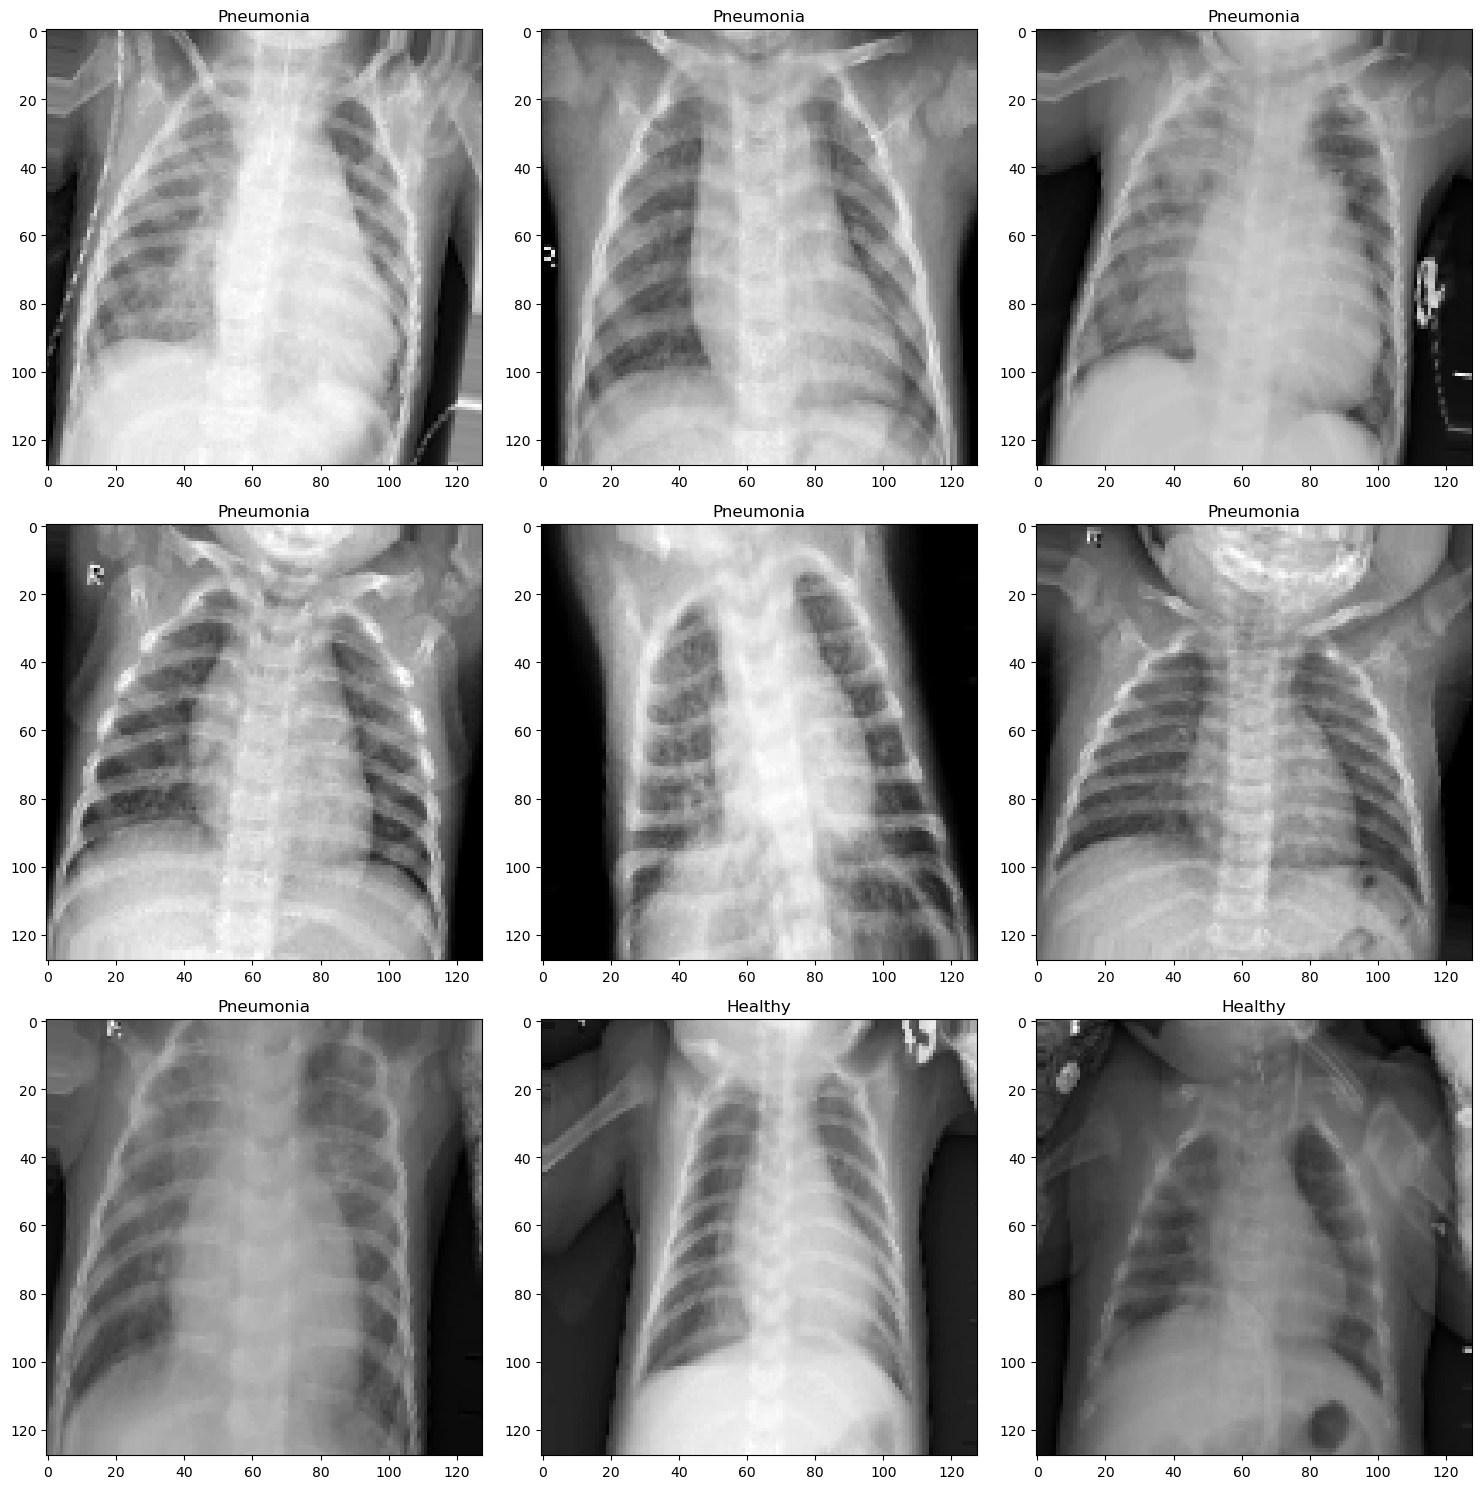

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
# Create list for labeling images
classes = ['Healthy', 'Pneumonia']
for i, ax in enumerate(axes.flat):
    img, label = train_gen1.next()
    for i in label[:9]:
        label = classes[int(i)]
    ax.imshow(img[0], cmap='gray')
    ax.set(title=f"{label}")
plt.tight_layout()
plt.show()

### Class balance
Before modeling, let's determine the balance of our classes

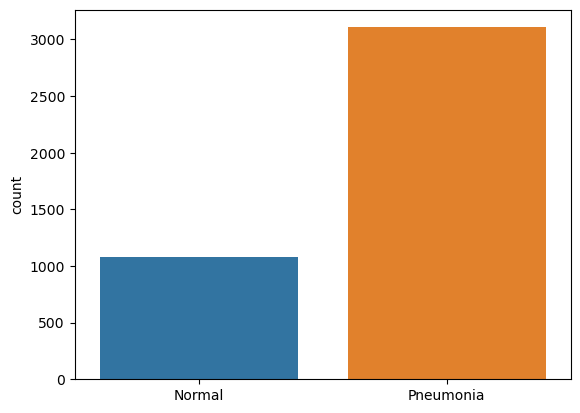

In [19]:
train_labels = train_gen1.classes
class_names = np.array(['Normal', 'Pneumonia'])
train_class_names = class_names[train_labels]
sns.countplot(x=train_class_names);

There is a class imbalance, but for now we'll move forward without addressing it in hopes our model can overcome this. If we later have classification issues we can revisit this topic.

## Model 1

### Structure
For our first model we'll structure it in a fairly conventional way. We'll use three convolutional layers, with Max Pooling layers in between. We'll take the output of those layers into a Dense layer, and funnel the output of that layer into our model's output layer. Because this is a binary classification problem, we'll use a Sigmoid activation function in our output layer.

### Metrics
Although overall accuracy is an important metric, it's vital that we minimize false negatives. Determining a patient is healthy when they actually have Pneumonia is highly undesirable. For this reason we will be using Recall as our primary metric. Recall measures the proportion of true positive cases (i.e., correctly predicted positives) out of all actual positive cases. So, by optimizing for recall, we are prioritizing the identification of all positive cases, even if this means that some true negatives may be misclassified as false positives. To be thorough we will also look at Precision and Accuracy.

In [20]:
model1 = Sequential(name='Model1')

# input_shape must match what's provided to the image generator
model1.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(128,128,1))) 
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(Flatten())

model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision', 'accuracy'])
model1.summary()

Metal device set to: Apple M2 Max
Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 flatten (Flatten)        

2023-05-12 17:01:41.120478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-12 17:01:41.121029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
results1 = model1.fit(train_gen1, epochs=25, workers=10, validation_data=val_gen1, validation_steps=100//train_gen1.batch_size)

Epoch 1/25


2023-05-12 17:01:42.175242: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-12 17:01:42.458364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.3621 - recall: 0.9446 - precision: 0.8552 - accuracy: 0.8402

2023-05-12 17:01:49.345201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 8s 52ms/step - loss: 0.3621 - recall: 0.9446 - precision: 0.8552 - accuracy: 0.8402 - val_loss: 0.1912 - val_recall: 0.9000 - val_precision: 1.0000 - val_accuracy: 0.9271
Epoch 2/25
131/131 [==============================] - 7s 49ms/step - loss: 0.1659 - recall: 0.9611 - precision: 0.9543 - accuracy: 0.9369 - val_loss: 0.0520 - val_recall: 1.0000 - val_precision: 0.9870 - val_accuracy: 0.9896
Epoch 3/25
131/131 [==============================] - 7s 49ms/step - loss: 0.1413 - recall: 0.9678 - precision: 0.9625 - accuracy: 0.9482 - val_loss: 0.1684 - val_recall: 0.9857 - val_precision: 0.9452 - val_accuracy: 0.9479
Epoch 4/25
131/131 [==============================] - 7s 50ms/step - loss: 0.1271 - recall: 0.9723 - precision: 0.9676 - accuracy: 0.9553 - val_loss: 0.1660 - val_recall: 0.9545 - val_precision: 0.9692 - val_accuracy: 0.9479
Epoch 5/25
131/131 [==============================] - 7s 50ms/step - loss: 0.1165 - recall: 0.9707 - precision:

In [22]:
model1.evaluate(eval_gen)

164/164 [==============================] - 16s 94ms/step - loss: 0.0403 - recall: 0.9907 - precision: 0.9930 - accuracy: 0.9880


[0.04028144106268883,
 0.9907288551330566,
 0.9930304288864136,
 0.9879587292671204]

In [24]:
model1.evaluate(test_gen1)

20/20 [==============================] - 2s 84ms/step - loss: 0.8583 - recall: 0.9897 - precision: 0.8126 - accuracy: 0.8510


[0.8583123683929443,
 0.9897436499595642,
 0.8126316070556641,
 0.8509615659713745]

In [25]:
model1_preds = (model1.predict(eval_gen) > 0.5).astype('int32')

2023-05-12 17:05:38.094679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 15s 89ms/step


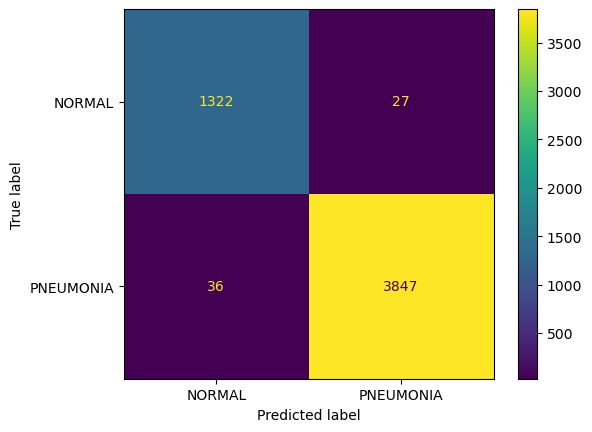

In [26]:
cm = ConfusionMatrixDisplay(confusion_matrix(eval_gen.classes, model1_preds), display_labels=list(eval_gen.class_indices.keys()))
cm.plot();

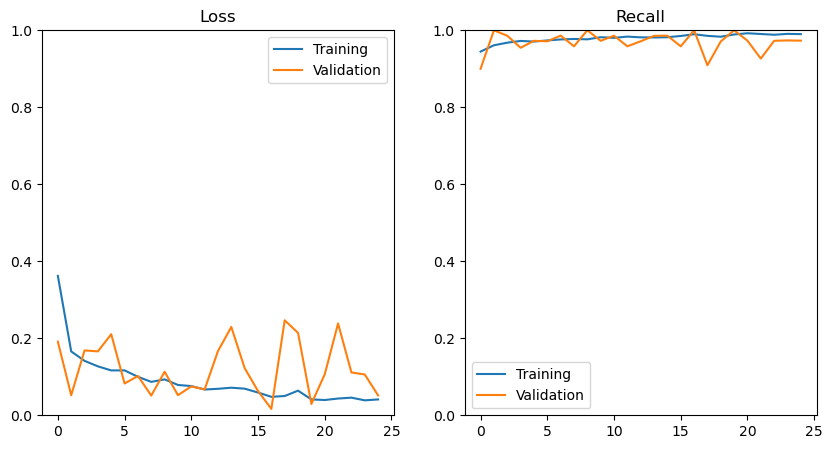

In [27]:
plot_history(results1)

This model looks pretty good, with a validation recall of 0.97. It's a strong start, but let's see if we can do better by introducing regularizaton and some more complexity, as we are not yet overfitting.

## Model 2

For this model we'll increasing complexity by adding another set of Convolutional/Max Pooling layers, as well as some Regularization in the form of a LayerNorm and Dropout.

In [28]:
model2 = Sequential(name='Model2')

model2.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(128,128,1)))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(Flatten())

model2.add(LayerNormalization())
model2.add(Dropout(0.2))

model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision', 'accuracy'])
model2.summary()

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)      0    

In [29]:
results2 = model2.fit(train_gen1, epochs=25, validation_data=val_gen1, validation_steps=100//32)

Epoch 1/25


2023-05-12 17:05:58.016876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.3687 - recall: 0.9517 - precision: 0.8710 - accuracy: 0.8596

2023-05-12 17:06:14.033589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 17s 118ms/step - loss: 0.3687 - recall: 0.9517 - precision: 0.8710 - accuracy: 0.8596 - val_loss: 0.1303 - val_recall: 0.9857 - val_precision: 0.9583 - val_accuracy: 0.9583
Epoch 2/25
131/131 [==============================] - 15s 113ms/step - loss: 0.1698 - recall: 0.9588 - precision: 0.9518 - accuracy: 0.9334 - val_loss: 0.1952 - val_recall: 1.0000 - val_precision: 0.9054 - val_accuracy: 0.9271
Epoch 3/25
131/131 [==============================] - 15s 113ms/step - loss: 0.1423 - recall: 0.9646 - precision: 0.9618 - accuracy: 0.9453 - val_loss: 0.0578 - val_recall: 1.0000 - val_precision: 0.9861 - val_accuracy: 0.9896
Epoch 4/25
131/131 [==============================] - 15s 115ms/step - loss: 0.1288 - recall: 0.9643 - precision: 0.9643 - accuracy: 0.9470 - val_loss: 0.1700 - val_recall: 0.9859 - val_precision: 0.9211 - val_accuracy: 0.9271
Epoch 5/25
131/131 [==============================] - 15s 117ms/step - loss: 0.1427 - recall: 0.9633 - 

In [30]:
model2.evaluate(eval_gen)

164/164 [==============================] - 15s 92ms/step - loss: 0.0522 - recall: 0.9773 - precision: 0.9966 - accuracy: 0.9807


[0.0521571971476078, 0.977337121963501, 0.9965862035751343, 0.9806957244873047]

In [31]:
model2_preds = (model2.predict(eval_gen) > 0.5).astype('int32')

2023-05-12 17:12:33.450296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 15s 89ms/step


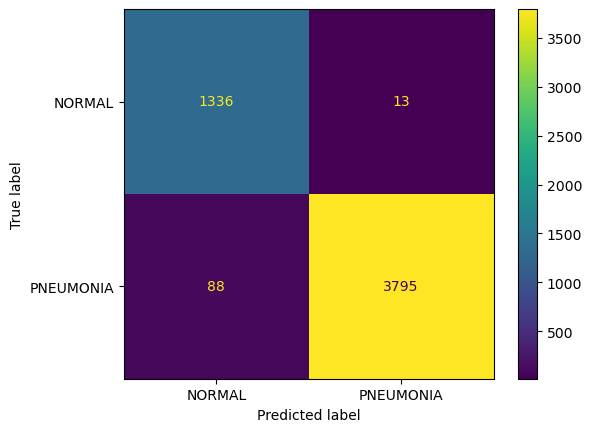

In [32]:
cm = ConfusionMatrixDisplay(confusion_matrix(eval_gen.classes, model2_preds), display_labels=list(eval_gen.class_indices.keys()))
cm.plot();

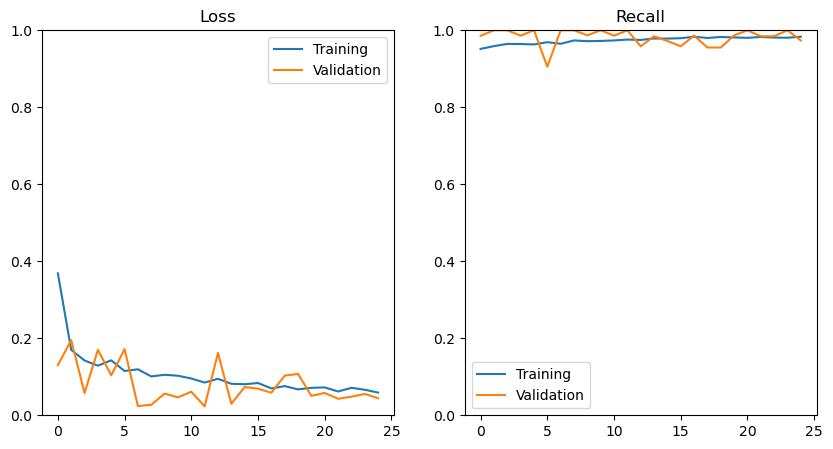

In [33]:
plot_history(results2)

### Interpretation

It seems that increasing regularization actually hurt our model in this instance. For next steps we can look at reducing the amount of regularization in order to better fit our goal of maximizing recall score. Although our precision increased, for the goals of our business problem, this model is unacceptable in terms of percentage of false negatives.

We're seeing significant variance in our validation recall scores. There could be multiple causes of this, such as too high a learning rate, or latent variation within our validation set. In addition, we are not doing an exhaustive validation check.

Our training set is 5232 images, 20% of which is split into validation set for each epoch, for a total validation size of 1045 images. We have our validation_steps parameter witin our model.fit() method set at `100//batch_size`. Because our batch_size is 32, this evaluates to 3 batches run through the model at each validation step, for a total of 96 images, or less than 10% of our total validaion set. This small sample size may well be the cause of the variance within the validation scores.

To account for this we could do an exhaustive validation set, as well as increase the batch sizes run through the model during training and validation. This is what we'll try for the next model.

## Model 3

For this next model we'll attempt to address the issues outlined above. In addition to this, there has been an issue with how we run our validation data during training. Because of the way we constructed our validation generator, we're passing the model augmented images. This is not correct. When the model is deployed it will be receiving unaugmented images, therefore to have accurate validation data we must do the same.

We can achieve this by creating two generators with the same random seed, where one augments the images and the other does not. This will ensure that our training and validation sets share no elements.

In [ ]:
# Generator for training set, augmented
train_gen3_1, val_gen3_1 = ImgGen(train_path)
print('---------')

# Generator for validation set, unaugmented
train_gen3_2, val_gen3_2 = ImgGen(train_path, img_size=(128,128), batch_size=128, brightness=None,rrange=0)

In [ ]:
model3 = Sequential(name='Model3')

# input_shape must match what's provided to the image generator
model3.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(128,128,1))) 
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(Flatten())

model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision', 'accuracy'])

In [36]:
results3 = model3.fit(train_gen3_1,epochs=50,workers=15, validation_data=val_gen3_2,validation_steps=None)

Epoch 1/50


2023-05-12 17:12:48.875902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.3125 - recall: 0.9482 - precision: 0.8823 - accuracy: 0.8677

2023-05-12 17:12:56.105510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 9s 61ms/step - loss: 0.3125 - recall: 0.9482 - precision: 0.8823 - accuracy: 0.8677 - val_loss: 0.1099 - val_recall: 0.9716 - val_precision: 0.9831 - val_accuracy: 0.9665
Epoch 2/50
131/131 [==============================] - 8s 57ms/step - loss: 0.1817 - recall: 0.9559 - precision: 0.9495 - accuracy: 0.9295 - val_loss: 0.1457 - val_recall: 0.9910 - val_precision: 0.9367 - val_accuracy: 0.9435
Epoch 3/50
131/131 [==============================] - 8s 56ms/step - loss: 0.1768 - recall: 0.9565 - precision: 0.9489 - accuracy: 0.9295 - val_loss: 0.1105 - val_recall: 0.9794 - val_precision: 0.9657 - val_accuracy: 0.9589
Epoch 4/50
131/131 [==============================] - 7s 55ms/step - loss: 0.1317 - recall: 0.9678 - precision: 0.9647 - accuracy: 0.9498 - val_loss: 0.0917 - val_recall: 0.9768 - val_precision: 0.9768 - val_accuracy: 0.9656
Epoch 5/50
131/131 [==============================] - 7s 55ms/step - loss: 0.1260 - recall: 0.9726 - precision:

131/131 [==============================] - 7s 55ms/step - loss: 0.0206 - recall: 0.9949 - precision: 0.9965 - accuracy: 0.9936 - val_loss: 0.0950 - val_recall: 0.9858 - val_precision: 0.9884 - val_accuracy: 0.9809
Epoch 38/50
131/131 [==============================] - 8s 55ms/step - loss: 0.0205 - recall: 0.9949 - precision: 0.9949 - accuracy: 0.9924 - val_loss: 0.1250 - val_recall: 0.9794 - val_precision: 0.9857 - val_accuracy: 0.9742
Epoch 39/50
131/131 [==============================] - 8s 56ms/step - loss: 0.0125 - recall: 0.9961 - precision: 0.9961 - accuracy: 0.9943 - val_loss: 0.1204 - val_recall: 0.9845 - val_precision: 0.9871 - val_accuracy: 0.9789
Epoch 40/50
131/131 [==============================] - 8s 55ms/step - loss: 0.0166 - recall: 0.9945 - precision: 0.9961 - accuracy: 0.9931 - val_loss: 0.1221 - val_recall: 0.9794 - val_precision: 0.9857 - val_accuracy: 0.9742
Epoch 41/50
131/131 [==============================] - 7s 55ms/step - loss: 0.0116 - recall: 0.9977 - precis

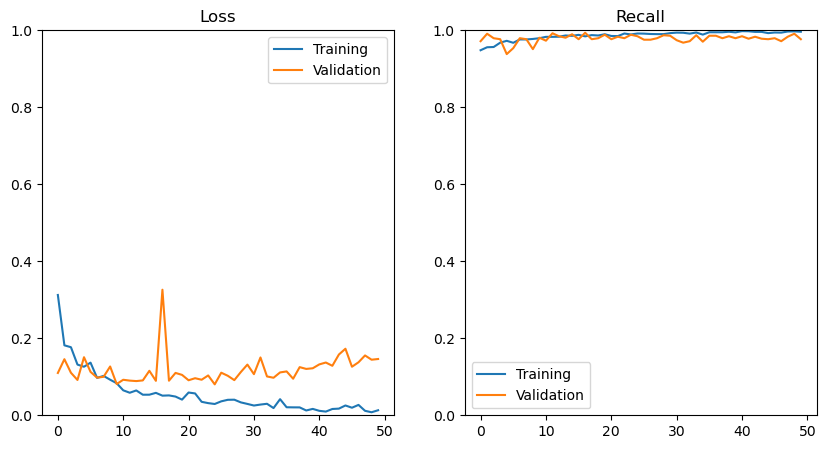

In [37]:
plot_history(results3)

## Model 4

For our next model, let's try scaling up the image size to see if our model can capture more detail to better discern patterns and structures within the X-Rays. We'll double the height and width, for 4x the number of pixels.

Since we're inputting a different shape to the model we need to specify new generators with our new dimensions.

In [40]:
train_gen4, val_gen4 = ImgGen(train_path, img_size=(256,256))

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [41]:
eval_datagen = ImageDataGenerator(rescale=1./255)
eval_gen4 = eval_datagen.flow_from_directory(train_path, target_size=(256,256), batch_size=32, class_mode='binary',
                                                  color_mode='grayscale', shuffle=False)

Found 5232 images belonging to 2 classes.


In [42]:
model4 = Sequential(name='Model4')

model4.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(256,256,1)))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(Flatten())

model4.add(LayerNormalization())
model4.add(Dropout(0.2))

model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision', 'accuracy'])
model4.summary()

Model: "Model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 128)     1280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 128)     147584    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 128)      0    

In [44]:
results4 = model4.fit(train_gen4, epochs=25, workers=15, validation_data=val_gen4, validation_steps=100//32)

Epoch 1/25
131/131 [==============================] - ETA: 0s - loss: 0.3226 - recall: 0.9771 - precision: 0.8664 - accuracy: 0.8713

2023-05-12 17:21:31.476785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 22s 167ms/step - loss: 0.3226 - recall: 0.9771 - precision: 0.8664 - accuracy: 0.8713 - val_loss: 0.2411 - val_recall: 1.0000 - val_precision: 0.9333 - val_accuracy: 0.9479
Epoch 2/25
131/131 [==============================] - 21s 161ms/step - loss: 0.2858 - recall: 0.9421 - precision: 0.9372 - accuracy: 0.9102 - val_loss: 0.2352 - val_recall: 0.9857 - val_precision: 0.9200 - val_accuracy: 0.9271
Epoch 3/25
131/131 [==============================] - 21s 159ms/step - loss: 0.2601 - recall: 0.9565 - precision: 0.9480 - accuracy: 0.9288 - val_loss: 0.2318 - val_recall: 0.9324 - val_precision: 1.0000 - val_accuracy: 0.9479
Epoch 4/25
131/131 [==============================] - 21s 158ms/step - loss: 0.2590 - recall: 0.9559 - precision: 0.9420 - accuracy: 0.9236 - val_loss: 0.1922 - val_recall: 0.9333 - val_precision: 1.0000 - val_accuracy: 0.9479
Epoch 5/25
131/131 [==============================] - 21s 159ms/step - loss: 0.2344 - recall: 0.9508 - 

In [45]:
model4.evaluate(eval_gen4)

164/164 [==============================] - 17s 104ms/step - loss: 0.0860 - recall: 0.9941 - precision: 0.9738 - accuracy: 0.9757


[0.08601349592208862,
 0.9940767884254456,
 0.9737638831138611,
 0.975726306438446]

In [47]:
model4_preds = (model4.predict(eval_gen4) > 0.5).astype('int32')

2023-05-12 17:31:08.524792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 16s 98ms/step


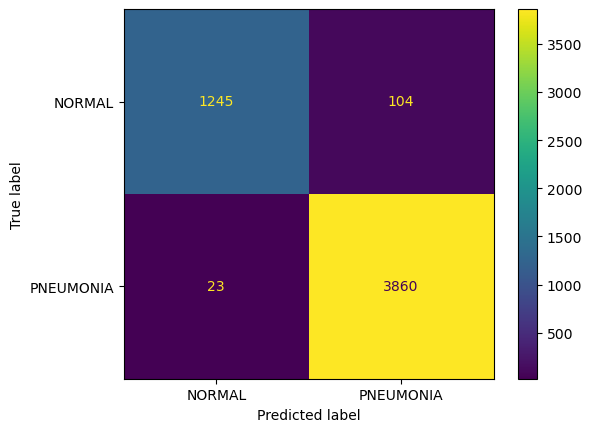

In [48]:
cm = ConfusionMatrixDisplay(confusion_matrix(eval_gen4.classes, model4_preds), display_labels=list(eval_gen4.class_indices.keys()))
cm.plot();

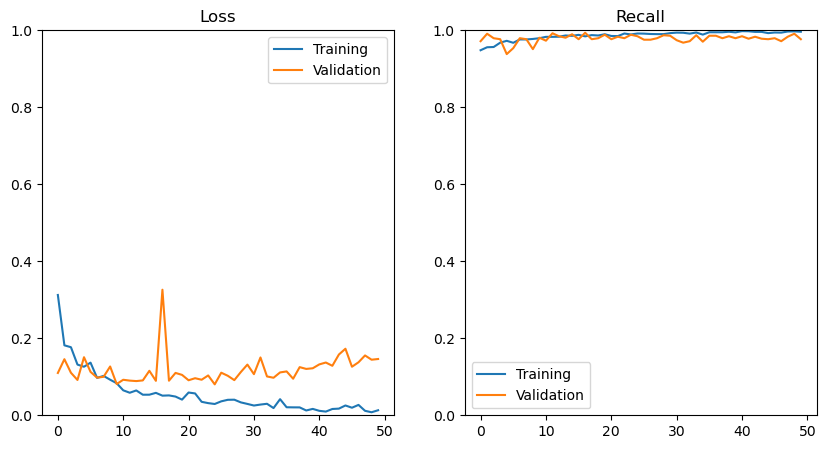

In [49]:
plot_history(results3)

This model is doing significantly worse. It seems that by increasing our image size but not also increasing the number of parameters and layers we were unable to correctly diagnose our images. As part of next steps we can look at modifying the model structure to incorporate more convolutional blocks as well as regularization techniques to prevent overfitting. In addition to this, adding aspects such as skip connections could help fight the vanishing gradient problem seen in deeper neural networks.

## Multi-class Exploration


The data contained two versions of pnemonia, viral and bacterial. The treatment of these two variants are very differnt and knowing which type is present can go a very long way to treating, if it could be identified from only the X-ray, proper treatment could be deployed immediately without having to wait for a follow up test like a bacterial culture to yeild results. Unfortunately the model was unable to pick up on a difference between Viral X-rays and Bacterial X-rays to correclty classify the two. Since the model is black box its difficult to determine what patterns it is seeing, but we think its is identifying the pressence of infiltrates in the lungs being illuminated by the Xrays. If this is the case it would mean that the model is incapible of distinguishing between the two conditions using only X-rays.

To explore the multi-class problem we need to create new filepaths and new generators.

In [51]:
train_path_3 = os.path.join(os.getcwd(), 'Data\\train_3')
test_path_3 = os.path.join(os.getcwd(), 'Data\\test_3')

bacterial_filenames = os.listdir(os.path.join(train_path_3, 'bacterial'))
viral_filenames = os.listdir(os.path.join(train_path_3, 'viral'))
normal_filenames = os.listdir(os.path.join(train_path_3, 'normal'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Gideon/Desktop/FlatIron/xrayid/Data/train_3/bacterial'

## Examples of Bacterial Pneumonia

In [ ]:
plt.figure(figsize=(15,15))
for i in range(3):
    filename = bacterial_filenames[i]
    img_addr = train_path_3 + '\\bacterial\\' + filename
    img = Image.open(img_addr)
    ax = plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')

## Examples of Viral Pneumonia

In [ ]:
plt.figure(figsize=(15,15))
for i in range(3):
    filename = viral_filenames[i]
    img_addr = train_path_3 + '\\viral\\' + filename
    img = Image.open(img_addr)
    ax = plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')

## Examples of Healthy Lungs

In [ ]:
plt.figure(figsize=(15,15))
for i in range(3):
    filename = normal_filenames[i]
    img_addr = train_path_3 + '\\normal\\' + filename
    img = Image.open(img_addr)
    ax = plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')

## Multi-Class Generators

In [ ]:
img_size = (128, 128)
batch_size = 64
brightness = [0.8, 1.2]
vsplit = 0.2
rrange = 10
seed = 2023

train_datagen_multi = ImageDataGenerator(validation_split=vsplit, rotation_range=rrange, fill_mode='nearest',
                                   brightness_range=brightness)

print('----')
train_gen_multi = train_datagen_multi.flow_from_directory(train_path_3, target_size=img_size, batch_size=batch_size,
                                                    class_mode='categorical', color_mode='grayscale', subset='training',
                                                    shuffle=True, seed=seed)
print('----')
val_gen_multi = train_datagen_multi.flow_from_directory(train_path_3, target_size=img_size, batch_size=batch_size,
                                                    class_mode='categorical', color_mode='grayscale', subset='validation',
                                                    shuffle=True, seed=seed)

print('----')
test_datagen_multi = ImageDataGenerator()
test_gen_multi = test_datagen_multi.flow_from_directory(test_path_3, target_size=img_size, batch_size=batch_size,
                                                  class_mode='categorical', color_mode='grayscale')

In [ ]:
model_multi = Sequential(name='ModelMulti')

model_multi.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(128,128,1)))
model_multi.add(MaxPooling2D(pool_size=(2,2)))

model_multi.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_multi.add(MaxPooling2D(pool_size=(2,2)))

model_multi.add(Conv2D(64, (3,3), activation='relu'))
model_multi.add(Flatten())

model_multi.add(Dense(64, activation='relu'))
model_multi.add(Dense(3, activation='softmax'))

model_multi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Recall', 'Precision', 'accuracy'])

model_multi.summary()

In [ ]:
results_multi = model_multi.fit(train_gen_multi, epochs=25, workers=10, validation_data=val_gen_multi,
                                validation_steps=100//batch_size)

In [ ]:
model_multi.evaluate(val_gen_multi)

In [ ]:
model_multi_preds = model_multi.predict(val_gen_multi).argmax(axis=1)

In [ ]:
model_multi_preds

In [ ]:
cm = ConfusionMatrixDisplay(confusion_matrix(val_gen_multi.classes, model_multi_preds), display_labels=list(val_gen_multi.class_indices.keys()))
cm.plot();

In [ ]:
plot_history(results_multi)

## Final Model Determination

Determining our final model will involve running our test data set through the model to identify which model achieves the best results on unseen data.

In [ ]:
model1.summary()

### Model 1

In [ ]:
model1.evaluate(test_gen1)

In [ ]:
model1_test_preds = (model1.predict(test_gen1) > 0.5).astype('int32')
cm = ConfusionMatrixDisplay(confusion_matrix(test_gen1.classes, model1_test_preds), display_labels=list(test_gen1.class_indices.keys()))
cm.plot();

## Model 2

In [ ]:
model2.evaluate(test_gen1)

In [ ]:
model2_test_preds = (model2.predict(test_gen1) > 0.5).astype('int32')
cm = ConfusionMatrixDisplay(confusion_matrix(test_gen1.classes, model2_test_preds), display_labels=list(test_gen1.class_indices.keys()))
cm.plot();

## Model 3

In [ ]:
model3.evaluate(test_gen1)

In [ ]:
model3_test_preds = (model3.predict(test_gen1) > 0.5).astype('int32')
cm = ConfusionMatrixDisplay(confusion_matrix(test_gen1.classes, model3_test_preds), display_labels=list(test_gen1.class_indices.keys()))
cm.plot();

## Model 4

In [ ]:
plot_history(results3)

In [ ]:
model3.evaluate(test_gen1)

In [ ]:
model3_test_preds = (model3.predict(test_gen1) > 0.5).astype('int32')
cm = ConfusionMatrixDisplay(confusion_matrix(test_gen1.classes, model3_test_preds), display_labels=list(test_gen1.class_indices.keys()))
cm.plot();

In [ ]:
model4.summary()